In [227]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import re
import seaborn
from lxml import html
import matplotlib

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [228]:
user_id = 12345

In [229]:
# establishing session
s = requests.Session() 
s.headers.update({
        'Referer': 'http://www.kinopoisk.ru',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:45.0) Gecko/20100101 Firefox/45.0'
    })

# User data

In [230]:
def load_user_data(user_id, page, session):
    url = 'http://www.kinopoisk.ru/user/%d/votes/list/ord/date/page/%d/#list' % (user_id, page)
    # print url
    request = session.get(url)
    return request.text

def contain_movies_data(text):
    soup = BeautifulSoup(text)
    film_list = film_list = soup.find('div', {'class': 'profileFilmsList'})
    return film_list is not None

def read_file(filename):
    with open(filename) as input_file:
        text = input_file.read()
    return text

def parse_user_datafile_bs(filename):
    results = []
    text = read_file(filename)
        
    soup = BeautifulSoup(text)
    film_list = soup.find('div', {'class': 'profileFilmsList'})
    items = film_list.find_all('div', {'class': ['item', 'item even']})
    for item in items:
        # getting movie_id
        movie_link = item.find('div', {'class': 'nameRus'}).find('a').get('href')
        movie_desc = item.find('div', {'class': 'nameRus'}).find('a').text
        movie_id = re.findall('\d+', movie_link)[0]
        
        # getting english name
        name_eng = item.find('div', {'class': 'nameEng'}).text
        
        #getting watch time
        watch_datetime = item.find('div', {'class': 'date'}).text
        date_watched, time_watched = re.match('(\d{2}\.\d{2}\.\d{4}), (\d{2}:\d{2})', watch_datetime).groups()
        
        # getting user rating
        user_rating = item.find('div', {'class': 'vote'}).text
        if user_rating:
            user_rating = int(user_rating)
            
        results.append({
                'movie_id': movie_id,
                'name_eng': name_eng,
                'date_watched': date_watched,
                'time_watched': time_watched,
                'user_rating': user_rating,
                'movie_desc': movie_desc
            })
    return results

def parse_user_datafile_lxml(filename):
    results = []
    text = read_file(filename)
    
    tree = html.fromstring(text)
    
    film_list_lxml = tree.xpath('//div[@class = "profileFilmsList"]')[0]
    items_lxml = film_list_lxml.xpath('//div[@class = "item even" or @class = "item"]')  
    for item_lxml in items_lxml:
        # getting movie id
        movie_link = item_lxml.xpath('.//div[@class = "nameRus"]/a/@href')[0]
        movie_desc = item_lxml.xpath('.//div[@class = "nameRus"]/a/text()')[0]
        movie_id = re.findall('\d+', movie_link)[0]

        # getting english name
        name_eng = item_lxml.xpath('.//div[@class = "nameEng"]/text()')[0]

        #getting watch time
        watch_datetime = item_lxml.xpath('.//div[@class = "date"]/text()')[0]
        date_watched, time_watched = re.match('(\d{2}\.\d{2}\.\d{4}), (\d{2}:\d{2})', watch_datetime).groups()

        # getting user rating
        user_rating = item_lxml.xpath('.//div[@class = "vote"]/text()')
        if user_rating:
            user_rating = int(user_rating[0])
            
        results.append({
                'movie_id': movie_id,
                'name_eng': name_eng,
                'date_watched': date_watched,
                'time_watched': time_watched,
                'user_rating': user_rating,
                'movie_desc': movie_desc
            })
    return results

In [223]:
# loading user viewed files
page = 1
while True:
    # print 'Loading page #%d' % (page)
    data = load_user_data(user_id, page, s)
    if contain_movies_data(data):
        with open('./user_data/page_%d.html' % (page), 'w') as output_file:
            output_file.write(data.encode('cp1251'))
            page += 1
    else:
            break

In [231]:
# parsing user data
results = []
for filename in os.listdir('./user_data/'):
    results.extend(parse_user_datafile_bs('./user_data/' + filename))

In [232]:
user_data_df = pd.DataFrame(results)
user_data_df['user_rating'] = pd.to_numeric(user_data_df.user_rating)

In [233]:
movies = user_data_df.movie_id.unique().tolist()

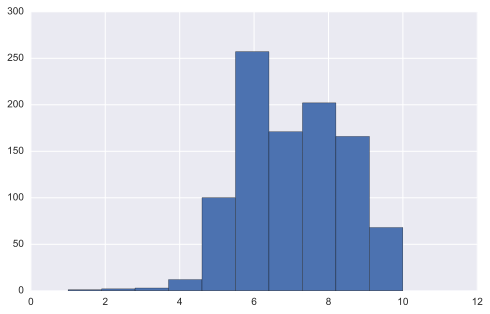

In [234]:
user_data_df.user_rating.hist()

In [235]:
user_data_df['date_watched'] = pd.to_datetime(user_data_df.date_watched, format = '%d.%m.%Y')

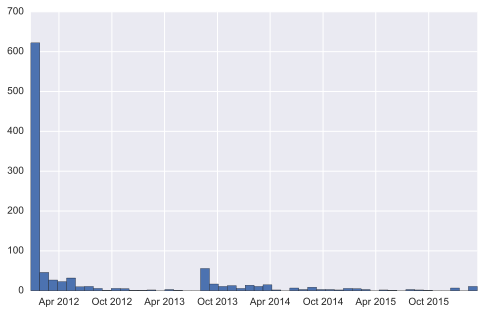

In [237]:
user_data_df.date_watched.hist(bins = 50)

In [238]:
user_data_df[780:790]

,date_watched,movie_desc,movie_id,name_eng,time_watched,user_rating
780,2012-12-09,Турист (2010),428715,The Tourist,12:48,8.0
781,2012-11-18,1+1 (2011),535341,Intouchables,23:29,6.0
782,2012-11-18,Третий лишний (2012),507817,Ted,23:26,5.0
783,2012-11-11,Опасные пассажиры поезда 123 (2009),400582,The Taking of Pelham 1 2 3,22:54,5.0
784,2012-11-11,Пароль «Рыба-меч» (2001),849,Swordfish,22:46,5.0
785,2012-11-03,Ищу друга на конец света (2011),464573,Seeking a Friend for the End of the World,22:44,7.0
786,2012-10-28,Казино Рояль (2006),49844,Casino Royale,12:51,8.0
787,2012-10-28,Золушка (1947),45398,,12:33,8.0
788,2012-10-28,Морозко (1964),46701,,12:32,NaN
789,2012-10-28,Темный рыцарь: Возрождение легенды (2012),437410,The Dark Knight Rises,00:12,10.0


# Movie Data

In [239]:
def load_movie_data(movie_id, session):
    url = 'http://www.kinopoisk.ru/film/%s/' % (movie_id)
    # print url
    request = session.get(url)
    return request.text

In [240]:
# loading movie data
for movie_id in movies:
    time.sleep(1)
     # print movie_id
    tmp = load_movie_data(movie_id, s)
    with open('./movie_data/%s.html' % (movie_id), 'w') as output_file:
        output_file.write(tmp.encode('cp1251'))

In [241]:
def parse_movie_datafile(filename):
    with open('./movie_data/' + filename) as input_file:
        text = input_file.read()
        
    movie_id = filename.replace('.html', '')
    
    soup = BeautifulSoup(text)
    
    name_eng = soup.find('span', {'itemprop': 'alternativeHeadline'}).text
    name_rus = soup.find('h1', {'class': 'moviename-big'}).text

    kp_rating = float(soup.find('span', {'class': 'rating_ball'}).text)
    
    critics_rating = None
    critics_rating_block = soup.find('div', {'class': 'criticsRating'})
    if critics_rating_block:
        critics_rating_num_block = critics_rating_block.find('div', {'class': 'ratingNum'})
        if critics_rating_num_block:
            critics_rating = int(critics_rating_num_block.find('span').text)
      
    imdb_rating = None
    imdb_block_text = soup.find('div', {'class': 'block_2'}).find(text = re.compile('^IMDb'))
    if imdb_block_text:
        imdb_rating = imdb_block_text.split()[1]
    
    info_table = soup.find('table', {'class': 'info'})
    
    movie_year = int(info_table.find('td', {'class': 'type'}, text = u'год').nextSibling.nextSibling.text[:5])
    movie_duration = int(info_table.find('td', {'class': 'type'}, text = u'время').nextSibling.text.split()[0])
    genres = map(lambda x: x.text, info_table.find('span', {'itemprop': 'genre'}).find_all('a'))
    countries = map(lambda x: x.text, info_table.find('td', {'class': 'type'}, text = u'страна').nextSibling.nextSibling.find_all('a'))
    
    movie = {
    'movie_id': movie_id,
    'name_eng': name_eng,
    'name_rus': name_rus,
    'kp_rating': kp_rating,
    'critics_rating': critics_rating,
    'imdb_rating': imdb_rating,
    'movie_year': movie_year,
    'movie_duration': movie_duration,
    'genres': genres,
    'countries': countries
    }
    
    return movie

In [242]:
movies = []

for filename in os.listdir('./movie_data/'):
    # print filename
    if filename.find('.html') != -1:
        movie = parse_movie_datafile(filename)
        movies.append(movie)

In [243]:
movie_data_df = pd.DataFrame(movies)

In [244]:
fin_df = user_data_df.merge(movie_data_df, on = 'movie_id')
fin_df[780:790]

,date_watched,movie_desc,movie_id,name_eng_x,time_watched,user_rating,countries,critics_rating,genres,imdb_rating,kp_rating,movie_duration,movie_year,name_eng_y,name_rus
780,2012-12-09,Турист (2010),428715,The Tourist,12:48,8.0,"[США, Франция, Италия]",20.0,"[боевик, триллер, мелодрама]",6.00,6.754,103,2010,The Tourist,Турист
781,2012-11-18,1+1 (2011),535341,Intouchables,23:29,6.0,[Франция],75.0,"[драма, комедия, биография]",8.60,8.829,112,2011,Intouchables,1+1
782,2012-11-18,Третий лишний (2012),507817,Ted,23:26,5.0,[США],68.0,"[фэнтези, комедия]",7.00,6.735,106,2012,Ted,Третий лишний
783,2012-11-11,Опасные пассажиры поезда 123 (2009),400582,The Taking of Pelham 1 2 3,22:54,5.0,"[США, Великобритания]",51.0,"[триллер, боевик, криминал]",6.40,7.049,102,2009,The Taking of Pelham 1 2 3,Опасные пассажиры поезда 123
784,2012-11-11,Пароль «Рыба-меч» (2001),849,Swordfish,22:46,5.0,"[США, Австралия]",26.0,"[боевик, триллер, криминал]",6.50,7.257,99,2001,Swordfish,Пароль «Рыба-меч»
785,2012-11-03,Ищу друга на конец света (2011),464573,Seeking a Friend for the End of the World,22:44,7.0,"[США, Сингапур, Малайзия, Индонезия]",56.0,"[мелодрама, драма, комедия, фантастика]",6.70,6.656,101,2011,Seeking a Friend for the End of the World,Ищу друга на конец света
786,2012-10-28,Казино Рояль (2006),49844,Casino Royale,12:51,8.0,"[Великобритания, Чехия, США, Германия, Багамы]",95.0,"[боевик, триллер, приключения]",8.00,7.753,139,2006,Casino Royale,Казино Рояль
787,2012-10-28,Золушка (1947),45398,,12:33,8.0,[СССР],NaN,"[мюзикл, фэнтези, мелодрама, комедия, семейный]",7.80,8.002,84,1947,,Золушка
788,2012-10-28,Морозко (1964),46701,,12:32,NaN,[СССР],NaN,"[фэнтези, мелодрама, комедия, семейный]",6.00,8.015,84,1964,,Морозко
789,2012-10-28,Темный рыцарь: Возрождение легенды (2012),437410,The Dark Knight Rises,00:12,10.0,"[США, Великобритания]",NaN,"[фантастика, боевик, триллер, драма, криминал]",8.50,8.165,165,2012,The Dark Knight Rises,Темный рыцарь: Возрождение легенды
